In [ ]:
# Reference

#https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/
#https://www.analyticsvidhya.com/blog/2021/01/image-classification-using-convolutional-neural-networks-a-step-by-step-guide/
#https://www.kaggle.com/alincijov/cnn-birds-tf-transfer-learning/notebook

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Manually Selected the Bird Species before and stored them in the folders seperately
top_path = '/content/drive/MyDrive/IC2/train_10'
birds = np.array(list(os.listdir(top_path)))

In [ ]:
# Printing the list of bird species
idx_to_name = {i:x for (i,x) in enumerate(birds)}
name_to_idx = {x:i for (i,x) in enumerate(birds)}
print(idx_to_name)

{0: 'AMERICAN GOLDFINCH', 1: 'CROW', 2: 'INDIAN PITTA', 3: 'MYNA', 4: 'WOOD DUCK', 5: 'ANTBIRD', 6: 'CANARY', 7: 'BARN OWL', 8: 'EMU', 9: 'TAKAHE'}


In [ ]:
# Labelling the Data
def get_data_labels(path, birds, dim):
    data = []
    labels = []

    for bird in birds:
        imgs = [cv2.resize(cv2.imread(img), dim, interpolation=cv2.INTER_AREA) for img in glob.glob(path + "/" + bird + "/*.jpg")]
        for img in imgs:
            data.append(img)
            labels.append(name_to_idx[bird])
    return np.array(data), np.array(labels)

In [ ]:
data_train, labels_train = get_data_labels('/content/drive/MyDrive/IC2/train_10', idx_to_name.values(), (224,224))
data_test, labels_test = get_data_labels('/content/drive/MyDrive/IC2/test_10', idx_to_name.values(), (224,224))
data_valid, labels_valid = get_data_labels('/content/drive/MyDrive/IC2/validate_10', idx_to_name.values(), (224,224))

In [ ]:
# Normalizing and One-hot Encoding
def normalize(data):
    data = data / 255.0
    data = data.astype('float32')
    return data

def one_hot(labels):
    labels = np.eye(len(np.unique(labels)))[labels]
    return labels

In [ ]:
data_train = normalize(data_train)
data_test = normalize(data_test)
data_valid = normalize(data_valid)

labels_train = one_hot(labels_train)
labels_test = one_hot(labels_test)
labels_valid = one_hot(labels_valid)

In [ ]:
# Removed weighted path
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Freezing the extraction layers
for layer in base_model.layers:
    layer.trainable = False
 
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
 
last_layer = base_model.get_layer('block5_pool')

last_output = last_layer.output
 
x = Flatten()(last_output)
 
# softmax layer
x = Dense(10, activation='softmax', name='softmax')(x)

In [ ]:
# keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)
 
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/IC2/birds.model.hdf5', save_best_only=True)
 
history = new_model.fit(data_train, labels_train, steps_per_epoch=len(data_train),
validation_data=(data_test, labels_test), validation_steps=3, epochs=10, verbose=1, callbacks=[checkpointer])

Epoch 1/10
1464/1464 [==============================] - 794s 542ms/step - loss: 0.7952 - accuracy: 0.7575 - val_loss: 0.3133 - val_accuracy: 0.9200
Epoch 2/10
1464/1464 [==============================] - 803s 548ms/step - loss: 0.1718 - accuracy: 0.9686 - val_loss: 0.1213 - val_accuracy: 0.9800
Epoch 3/10
1464/1464 [==============================] - 796s 543ms/step - loss: 0.0658 - accuracy: 0.9932 - val_loss: 0.1006 - val_accuracy: 0.9600
Epoch 4/10
1464/1464 [==============================] - 800s 546ms/step - loss: 0.0278 - accuracy: 0.9986 - val_loss: 0.0625 - val_accuracy: 0.9800
Epoch 5/10
1464/1464 [==============================] - 798s 545ms/step - loss: 0.0164 - accuracy: 0.9986 - val_loss: 0.0800 - val_accuracy: 0.9800
Epoch 6/10
1464/1464 [==============================] - 796s 544ms/step - loss: 0.0130 - accuracy: 0.9980 - val_loss: 0.0564 - val_accuracy: 0.9800
Epoch 7/10
1464/1464 [==============================] - 802s 548ms/step - loss: 0.0072 - accuracy: 0.9986 - val_

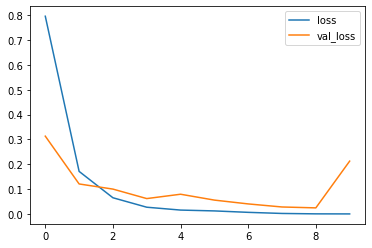

In [ ]:
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

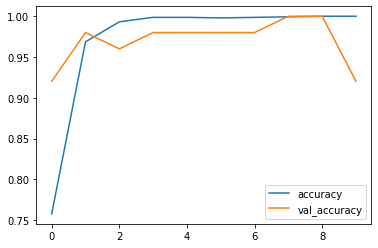

In [ ]:
#Accuracy
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
def get_accuracy(model, data_valid, labels_valid):
    predictions = model(data_valid)
    wrong = 0
    for i, pred in enumerate(predictions):
        if( np.argmax(pred) !=  np.argmax(labels_valid[i])):
            wrong += 1
    return (len(data_valid) - wrong) / len(data_valid)

In [ ]:
accuracy = get_accuracy(new_model, data_valid, labels_valid)
print("Accuracy:", accuracy)

Accuracy: 0.9
